the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '22/03/99' to '1999-03-22''. [astropy.wcs.wcs]


Images: 1, Galaxy fibers: 2


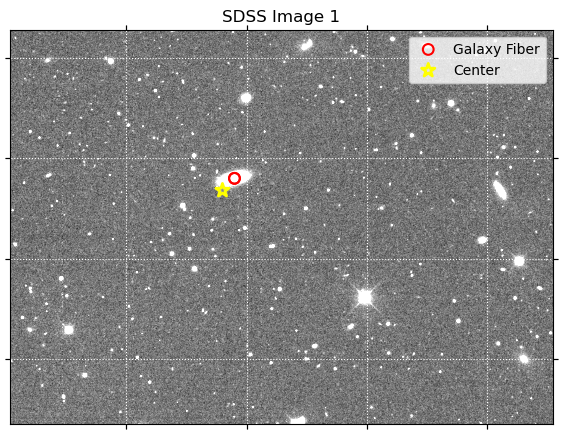

In [19]:
# %%
import numpy as np
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
from astropy.wcs import WCS
import matplotlib.pyplot as plt

# %%
# %%
# 1) SDSS 데이터 가져오기 함수 정의
#    - query_region(spectro=True)로 SpecObjAll 정보를 조회 후,
#      'class'=='GALAXY'인 fiber만 필터해 반환

def fetch_sdss_data(ra: float, dec: float, radius_arcmin: float = 2.0):
    """
    지정한 RA/Dec 주변의 SDSS 이미지를 가져오고,
    class='GALAXY'인 스펙트럴 fiber 위치 및 스펙트럼을 조회합니다.

    Returns
    -------
    images : list of HDUList
    galaxy_fibers : astropy.table.Table
        ra, dec, plate, mjd, fiberID, class 컬럼 포함
    spectra : dict
        {(plate, mjd, fiberID): HDUList}
    center_coord : SkyCoord
        입력 좌표
    """
    center_coord = coords.SkyCoord(ra=ra * u.deg,
                                   dec=dec * u.deg,
                                   frame='icrs')
    # 이미지 조회
    images = SDSS.get_images(coordinates=center_coord,
                              radius=radius_arcmin * u.arcmin)
    # SpecObjAll 정보 조회
    fiber_table = SDSS.query_region(
        coordinates=center_coord,
        radius=radius_arcmin * u.arcmin,
        spectro=True,
        fields=['ra','dec','plate','mjd','fiberID','class']
    )
    # GALAXY만 필터
    if fiber_table is None:
        return images, None, {}, center_coord
    galaxy_fibers = fiber_table[fiber_table['class'] == 'GALAXY']
    # 스펙트럼 조회
    spectra = {}
    for row in galaxy_fibers:
        plate = int(row['plate'])
        mjd = int(row['mjd'])
        fiber = int(row['fiberID'])
        spectra[(plate, mjd, fiber)] = SDSS.get_spectra(
            plate=plate, mjd=mjd, fiberID=fiber)
    return images, galaxy_fibers, spectra, center_coord

# %%
# 2) visualization 함수 (변경 없음)

def plot_sdss_image_with_fibers(images, fiber_table, center_coord):
    """SDSS 이미지 위에 GALAXY fiber와 입력 좌표를 오버레이"""
    for idx,hdu_list in enumerate(images):
        hdu = hdu_list[0]; wcs = WCS(hdu.header); data = hdu.data
        plt.figure(figsize=(7,7)); ax = plt.subplot(projection=wcs)
        ax.imshow(data,origin='lower',cmap='gray',
                  vmin=np.nanpercentile(data,5),vmax=np.nanpercentile(data,95))
        if fiber_table is not None and len(fiber_table)>0:
            sky = coords.SkyCoord(fiber_table['ra']*u.deg,
                                   fiber_table['dec']*u.deg, frame='icrs')
            x,y = wcs.world_to_pixel(sky)
            ax.scatter(x,y,s=60,edgecolor='red',facecolor='none',
                       lw=1.5,label='Galaxy Fiber')
        xc,yc = wcs.world_to_pixel(center_coord)
        ax.scatter(xc,yc,s=100,marker='*',edgecolor='yellow',
                   facecolor='none',lw=2,label='Center')
        ax.set_xlabel('RA'); ax.set_ylabel('Dec')
        ax.legend(loc='upper right'); ax.coords.grid(ls='dotted',color='white')
        ax.set_title(f'SDSS Image {idx+1}'); plt.show()

# %%
# 사용 예시
ra,dec=180.07,0.29
images,galaxy_fibers,spectra,center=fetch_sdss_data(ra,dec)
print(f"Images: {len(images)}, Galaxy fibers: {len(galaxy_fibers) if galaxy_fibers is not None else 0}")
plot_sdss_image_with_fibers(images,galaxy_fibers,center)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '22/03/99' to '1999-03-22''. [astropy.wcs.wcs]


Images: 1, All Fibers: 4
Galaxy Fibers: 2


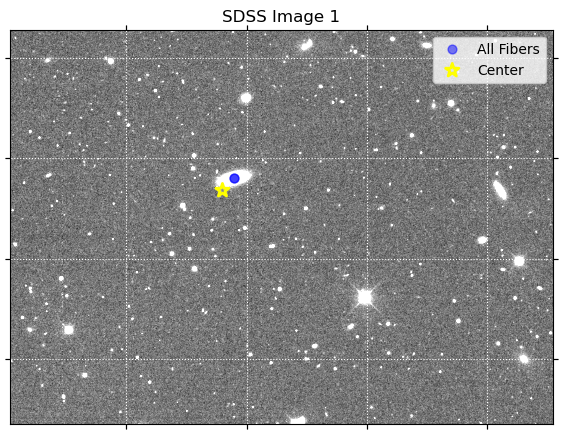

In [27]:
# %%
import numpy as np
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
from astropy.wcs import WCS
import matplotlib.pyplot as plt

# %%
# 1) SDSS 데이터 가져오기 함수 정의
#    - query_region(spectro=True)로 모든 SpecObj 정보를 조회
#    - 'class' 컬럼으로 GALAXY fiber만 필터하여 스펙트럼을 가져옵니다
def fetch_sdss_data(ra: float, dec: float, radius_arcmin: float = 2.0):
    """
    지정한 RA/Dec 주변의 SDSS 이미지를 가져오고,
    SpecObjAll에서 spectro=True로 모든 fiber 정보를 읽은 뒤,
    class=='GALAXY' fiber에 대해서만 스펙트럼을 조회합니다.

    Returns
    -------
    images : list of HDUList
        불러온 SDSS 이미지
    fibers : astropy.table.Table
        모든 fiber 위치 정보 (ra, dec, plate, mjd, fiberID, class)
    galaxy_fibers : astropy.table.Table
        class=='GALAXY'로 필터된 fiber 정보
    spectra : dict
        {(plate, mjd, fiberID): HDUList} 형식의 스펙트럼
    center_coord : SkyCoord
        입력된 중심 좌표
    """
    center_coord = coords.SkyCoord(ra=ra * u.deg,
                                   dec=dec * u.deg,
                                   frame='icrs')
    # SDSS 이미지 조회
    images = SDSS.get_images(coordinates=center_coord,
                              radius=radius_arcmin * u.arcmin)
    # 모든 fiber 정보 조회 (class 포함)
    fibers = SDSS.query_region(
        coordinates=center_coord,
        radius=radius_arcmin * u.arcmin,
        spectro=True,
        fields=['ra','dec','plate','mjd','fiberID','class']
    )
    # GALAXY fiber만 필터
    if fibers is not None and 'class' in fibers.colnames:
        galaxy_fibers = fibers[fibers['class'] == 'GALAXY']
    else:
        galaxy_fibers = None
    # 스펙트럼 조회: plate/mjd/fiberID로 get_spectra 호출
    spectra = {}
    if galaxy_fibers is not None and len(galaxy_fibers) > 0:
        for row in galaxy_fibers:
            plate = int(row['plate'])
            mjd = int(row['mjd'])
            fiber = int(row['fiberID'])
            spec_list = SDSS.get_spectra(plate=plate,
                                         mjd=mjd,
                                         fiberID=fiber)
            if spec_list:
                spectra[(plate, mjd, fiber)] = spec_list[0]
    return images, fibers, galaxy_fibers, spectra, center_coord

# %%
# 2) 이미지와 fiber 위치 시각화 함수
def plot_sdss_image_with_fibers(images, fibers, center_coord):
    """
    SDSS 이미지 위에 모든 fiber 위치와 입력 좌표를 오버레이합니다.
    """
    for idx, hdu_list in enumerate(images):
        hdu = hdu_list[0]; wcs = WCS(hdu.header); data = hdu.data
        fig = plt.figure(figsize=(7,7)); ax = plt.subplot(projection=wcs)
        ax.imshow(data, origin='lower', cmap='gray',
                  vmin=np.nanpercentile(data,5), vmax=np.nanpercentile(data,95))
        # 모든 fiber 표시
        if fibers is not None and len(fibers) > 0:
            sky_all = coords.SkyCoord(fibers['ra']*u.deg,
                                       fibers['dec']*u.deg,
                                       frame='icrs')
            x_all, y_all = wcs.world_to_pixel(sky_all)
            ax.scatter(x_all, y_all, s=40, c='blue',
                       marker='o', label='All Fibers', alpha=0.5)
        # 중심 표시
        xc, yc = wcs.world_to_pixel(center_coord)
        ax.scatter(xc, yc, s=100, marker='*',
                   edgecolor='yellow', facecolor='none',
                   lw=2, label='Center')
        ax.set_xlabel('RA'); ax.set_ylabel('Dec')
        ax.legend(loc='upper right'); ax.coords.grid(ls='dotted', color='white')
        ax.set_title(f'SDSS Image {idx+1}'); plt.show()

# %%
# 3) GALAXY fiber의 스펙트럼 시각화 함수
def plot_galaxy_spectra(spectra_dict):
    """
    class=='GALAXY' fiber에서 가져온 스펙트럼을 그립니다.
    """
    for key, hdu in spectra_dict.items():
        spec_data = hdu[1].data
        flux = spec_data['flux']
        loglam = spec_data['loglam']
        wavelength = 10 ** loglam
        plt.figure(figsize=(10,4))
        plt.plot(wavelength, flux)
        plt.title(f'Galaxy Spectrum: Plate {key[0]}, MJD {key[1]}, Fiber {key[2]}')
        plt.xlabel('Wavelength (Å)'); plt.ylabel('Flux')
        plt.xlim(wavelength.min(), wavelength.max()); plt.tight_layout(); plt.show()

# %%
# 4) 사용 예시
ra, dec = 180.07, 0.29  # deg
images, fibers, galaxy_fibers, spectra, center = fetch_sdss_data(ra, dec)
print(f"Images: {len(images)}, All Fibers: {len(fibers) if fibers is not None else 0}")
print(f"Galaxy Fibers: {len(galaxy_fibers) if galaxy_fibers is not None else 0}")
plot_sdss_image_with_fibers(images, galaxy_fibers, center)
plot_galaxy_spectra(spectra)


In [68]:
plate, mjd, fiber = 285, 51930, 190

sp = SDSS.query_specobj(plate=plate, mjd=mjd, fiberID=fiber)

sp

ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d
float64,float64,uint64,int64,int64,int64,int64,float64,int64,int64,int64,uint64,int64
179.85927482977,-0.43209395825067,1237648720693821710,756,301,2,428,0.08288149,285,51930,190,320933732632520704,26


In [48]:
sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber)

sp[0].writeto('spectrum_test.fits', overwrite=True)

In [82]:
plt.rcParams["font.family"] = 'STIXGeneral'
plt.rcParams['text.usetex'] = False
plt.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams["axes.labelweight"] = "bold"

plt.rcParams.update({'font.size': 40})
plt.rcParams.update({'font.weight': 'normal'})

plt.rcParams.update({'xtick.direction': 'in'})
plt.rcParams.update({'ytick.direction': 'in'})
plt.rcParams.update({'xtick.major.size': 20})
plt.rcParams.update({'xtick.minor.size': 12})
plt.rcParams.update({'ytick.major.size': 20})
plt.rcParams.update({'ytick.minor.size': 12})
plt.rcParams.update({'xtick.major.width': 2})
plt.rcParams.update({'xtick.minor.width': 2})
plt.rcParams.update({'ytick.major.width': 2})
plt.rcParams.update({'ytick.minor.width': 2})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'axes.linewidth': 4})
plt.rcParams.update({'axes.labelpad': 4})
plt.rcParams.update({'xtick.major.pad': 20})
plt.rcParams.update({'ytick.major.pad': 12})
plt.rcParams.update({'image.origin':'lower'})

Text(0, 0.5, '$\\mathrm{f_\\lambda\\ [10^{-17}erg\\cdot s^{-1}cm^{-2}\\AA^{-2}]}$')

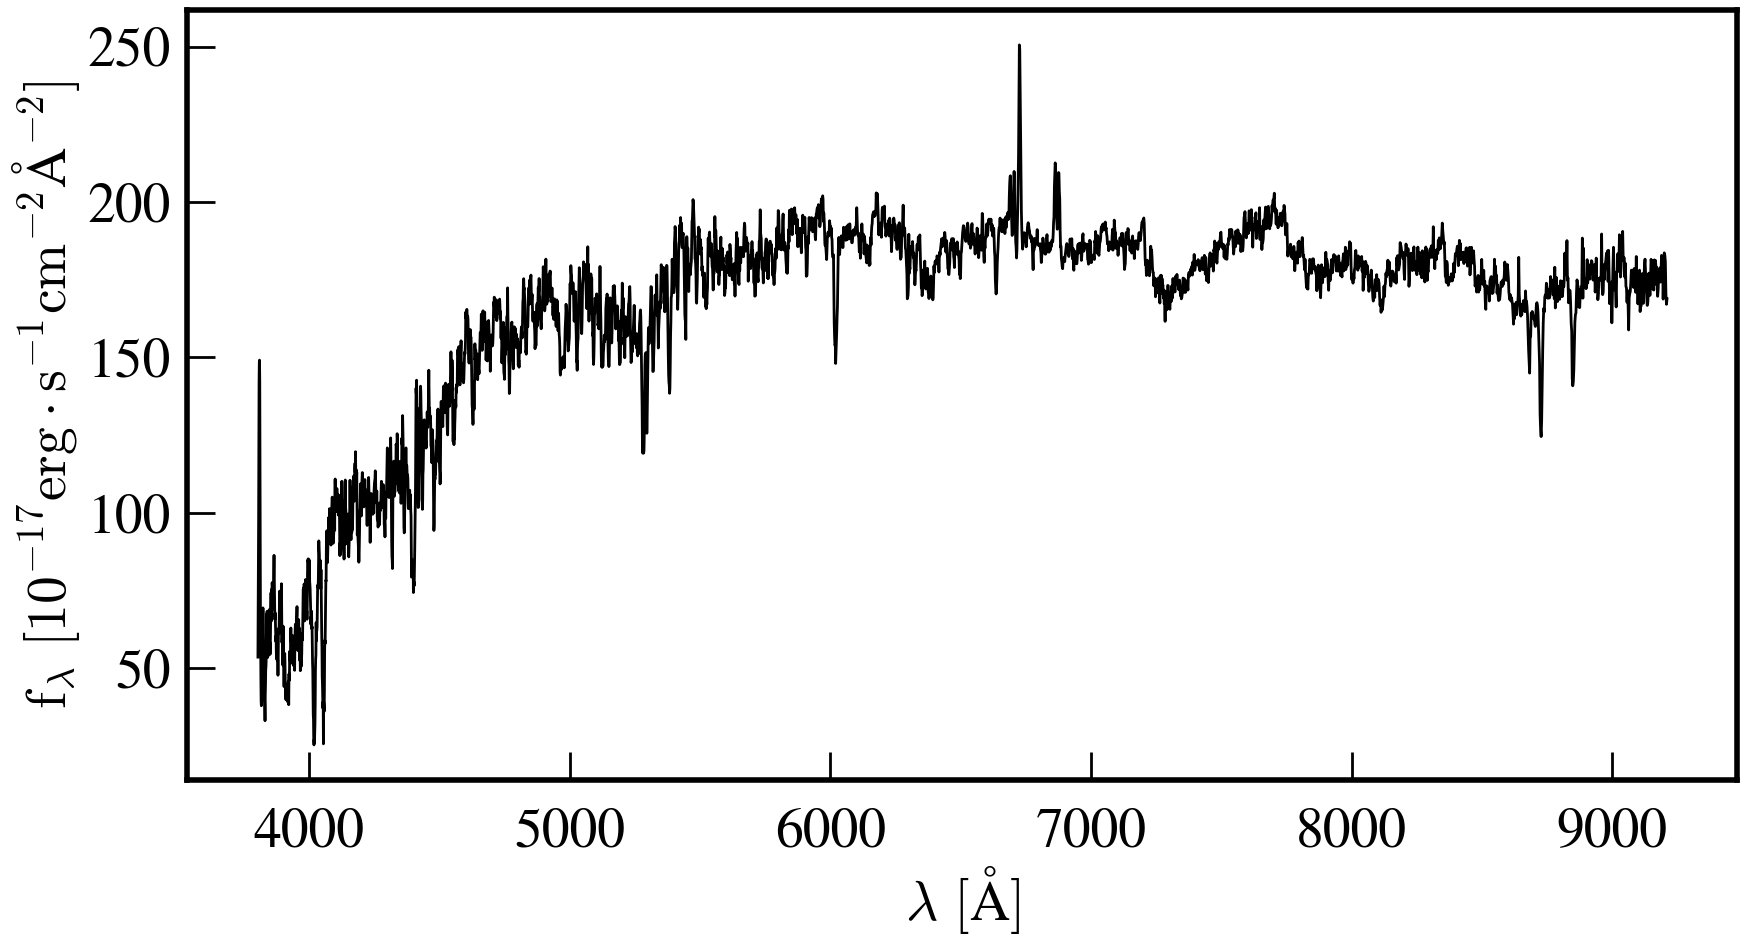

In [83]:
ra, dec = 195.83, 14.38
coord = coords.SkyCoord(ra, dec, unit="deg", frame='icrs')
xid = SDSS.query_region(coord, spectro=True, radius=1*u.arcmin, photoobj_fields=['r', 'objid'],
                            specobj_fields=['ra', 'dec', 'plate', 'mjd', 'fiberID'], timeout=300)

plate, mjd, fiberid = xid['plate'][0], xid['mjd'][0], xid['fiberID'][0]

sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiberid)[0]
#sp.writeto(f'{plate}_{mjd}_{fiberid}.fits', overwrite=True) - if you want to save the file

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(10 ** sp[1].data['loglam'], sp[1].data['flux'], c='k')

ax.set_xlabel('$\mathrm{\lambda\ [\AA]}$')
ax.set_ylabel('$\mathrm{f_\lambda\ [10^{-17}erg\cdot s^{-1}cm^{-2}\AA^{-2}]}$')
#ax.set_title(f'plate={plate}, mjd={mjd}, fiberID={fiberid}')

In [58]:
import astropy.io.fits as fits

spo = fits.open('spectrum_test.fits')
dat = spo[1].data

dat['flux']

array([16.995739 , 10.615022 ,  5.6342206, ..., 15.375724 , 16.850111 ,
       16.401266 ], dtype='>f4')

In [88]:
0.432/ (2 * np.pi * 2 * np.pi / 24 / 3600 / 1.35 * np.cos(np.pi/6) * np.cos((20 + 6/60 + 30.6/3600) * np.pi/180))

1569.4782083265932

In [80]:
from astroquery.ned import Ned
from astropy import units as u
from astropy.coordinates import SkyCoord

ra, dec = sp['ra'], sp['dec']

# 1) SDSS에서 얻은 좌표로 SkyCoord 생성
coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')

# 2) 반경 5 arcsec 내 NED 객체 찾기
ned_tbl_list = Ned.query_region(coord, radius=5*u.arcsec)

# 3) 가장 가까운 객체 선택
if len(ned_tbl_list) > 0:
    # NED.query_region 반환은 astropy Table 리스트
    main_match = ned_tbl_list[0]  
    ned_name = main_match['Object Name']
    print(f"매칭된 NED 이름: {ned_name}")
    
    # 4) Basic Data (redshift, morphological type 등) 테이블 얻기
    basic = Ned.get_table(ned_name)
    
    # 5) Photometry 테이블 얻기 (밴드별 광도 등)
    phot = Ned.get_table(ned_name, table='photometry')

else:
    print("NED에서 매칭되는 객체를 찾지 못했습니다.")


매칭된 NED 이름: WISEA J115926.23-002555.6


In [ ]:
z_tbl = Ned.get_table(ned_name, table='')

['No.', 'Observed Passband', 'Photometry Measurement', 'Uncertainty', 'Units', 'Frequency', 'Flux Density', 'Upper limit of uncertainty', 'Lower limit of uncertainty', 'Upper limit of Flux Density', 'Lower limit of Flux Density', 'NED Uncertainty', 'NED Units', 'Refcode', 'Significance', 'Published frequency', 'Frequency Mode', 'Coordinates Targeted', 'Spatial Mode', 'Qualifiers', 'Comments']
No. Observed Passband Photometry Measurement Uncertainty Units     Frequency      Flux Density Upper limit of uncertainty Lower limit of uncertainty Upper limit of Flux Density Lower limit of Flux Density NED Uncertainty NED Units       Refcode       Significance Published frequency     Frequency Mode               Coordinates Targeted                Spatial Mode                    Qualifiers                   Comments    
                                                                       Hz              Jy                                                                                        

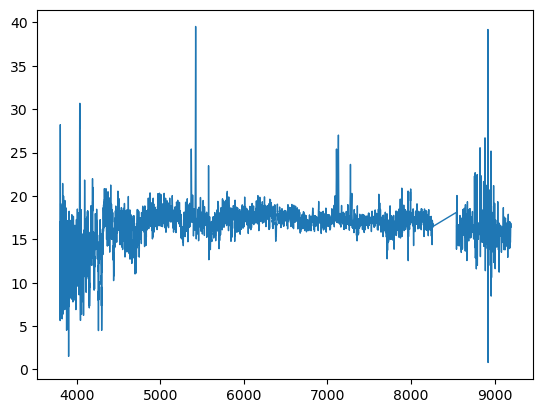

In [67]:
plt.plot(10 ** dat['loglam'], dat['flux'], linewidth=1)
#plt.xlim(4000, 4500)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '22/03/99' to '1999-03-22''. [astropy.wcs.wcs]


Images: 1, Fibers: 4


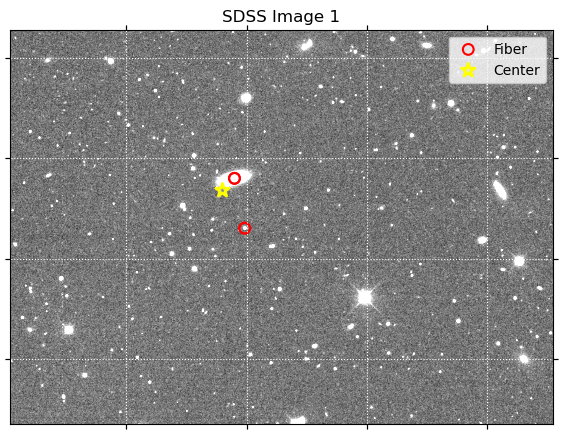

In [18]:
# %%
import numpy as np
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
from astropy.wcs import WCS
import matplotlib.pyplot as plt

# %%
# 1) SDSS 데이터 가져오기 함수 정의
#    - query_region(spectro=True)로 모든 SpecObjAll 정보를 조회 후 반환

def fetch_sdss_data(ra: float, dec: float, radius_arcmin: float = 2.0):
    """
    지정한 RA/Dec 주변의 SDSS 이미지를 가져오고,
    해당 영역을 커버하는 모든 스펙트럴 fiber 위치와 스펙트럼을 조회합니다.

    Parameters
    ----------
    ra : float (deg)
    dec : float (deg)
    radius_arcmin : float
        검색 반경 (arcmin)

    Returns
    -------
    images : list of HDUList
    fibers : astropy.table.Table
        ra, dec, plate, mjd, fiberID 컬럼 포함
    spectra : dict
        {(plate, mjd, fiberID): HDUList}
    center_coord : SkyCoord
        입력 좌표
    """
    # 중심 좌표 생성
    center_coord = coords.SkyCoord(ra=ra * u.deg,
                                   dec=dec * u.deg,
                                   frame='icrs')
    # 1-1) SDSS 이미지 조회
    images = SDSS.get_images(coordinates=center_coord,
                             radius=radius_arcmin * u.arcmin)

    # 1-2) SpecObjAll의 모든 fiber 정보 조회
    fibers = SDSS.query_region(
        coordinates=center_coord,
        radius=radius_arcmin * u.arcmin,
        spectro=True,
        fields=['ra', 'dec', 'plate', 'mjd', 'fiberID']
    )

    # 1-3) spectra 딕셔너리 생성
    spectra = {}
    if fibers is not None:
        for row in fibers:
            plate = int(row['plate'])
            mjd = int(row['mjd'])
            fiber = int(row['fiberID'])
            spectra[(plate, mjd, fiber)] = SDSS.get_spectra(
                plate=plate, mjd=mjd, fiberID=fiber)

    return images, fibers, spectra, center_coord

# %%
# 2) visualization 함수 정의

def plot_sdss_image_with_fibers(images, fibers, center_coord):
    """
    SDSS 이미지 위에 모든 fiber 위치와 입력 좌표를 오버레이합니다.

    Parameters
    ----------
    images : list of HDUList
    fibers : astropy.table.Table
    center_coord : SkyCoord
    """
    for idx, hdu_list in enumerate(images):
        hdu = hdu_list[0]
        wcs = WCS(hdu.header)
        data = hdu.data

        plt.figure(figsize=(7, 7))
        ax = plt.subplot(projection=wcs)
        ax.imshow(data, origin='lower', cmap='gray',
                  vmin=np.nanpercentile(data, 5),
                  vmax=np.nanpercentile(data, 95))

        # fiber positions
        if fibers is not None and len(fibers) > 0:
            sky = coords.SkyCoord(fibers['ra'] * u.deg,
                                  fibers['dec'] * u.deg,
                                  frame='icrs')
            x, y = wcs.world_to_pixel(sky)
            ax.scatter(x, y, s=60,
                       edgecolor='red', facecolor='none',
                       lw=1.5, label='Fiber')

        # center position
        xc, yc = wcs.world_to_pixel(center_coord)
        ax.scatter(xc, yc, s=100, marker='*',
                   edgecolor='yellow', facecolor='none',
                   lw=2, label='Center')

        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        ax.legend(loc='upper right')
        ax.coords.grid(ls='dotted', color='white')
        ax.set_title(f'SDSS Image {idx+1}')
        plt.show()

# %%
# 3) 사용 예시
ra, dec = 180.07, 0.29  # deg
images, fibers, spectra, center = fetch_sdss_data(ra, dec)
print(f"Images: {len(images)}, Fibers: {len(fibers) if fibers is not None else 0}")
plot_sdss_image_with_fibers(images, fibers, center)


In [7]:
fibers

ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d
float64,float64,uint64,int64,int64,int64,int64,float64,int64,int64,int64,uint64,str7
179.995204467694,-0.0147730008874498,1237648721230758225,756,301,3,429,2.191792,3843,55278,38,4326843875908147200,v5_13_2
